## Advanced Lane Finding

### Udacity Self Driving Car Engineer Nanodegree - Project 4

The goal of this project is to develop a pipeline to process a video stream from a forward-facing camera mounted on the front of a car, and output an annotated video which identifies:

1. The positions of the lane lines
2. The location of the vehicle relative to the center of the lane
3. The radius of curvature of the road
4. The pipeline created for this project processes images in the following steps:

Steps:

* Step 1: Apply distortion correction using a calculated camera calibration matrix and distortion coefficients.
* Step 2: Apply a perspective transformation to warp the image to a birds eye view perspective of the lane lines.
* Step 3: Use color transforms, gradients, etc., to create a thresholded binary image.
* Step 4: Identify the lane line pixels and fit polynomials to the lane boundaries.
* Step 5: Determine curvature of the lane and vehicle position with respect to center.
* Step 6: Warp the detected lane boundaries back onto the original image.
* Step 7: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Imports

In [1]:
from IPython.display import Image
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Configuration

In [2]:
## Include the plots into the saved jupyter notebook (good for displaying on github, etc)
%matplotlib inline

## Step 1: Distortion Correction

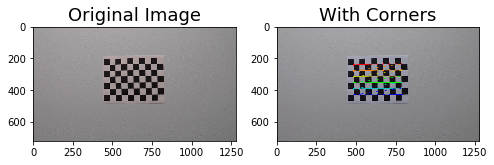

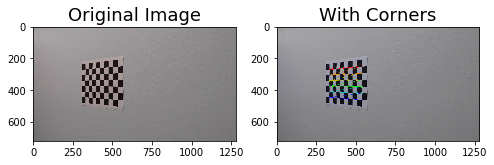

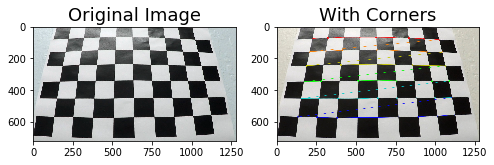

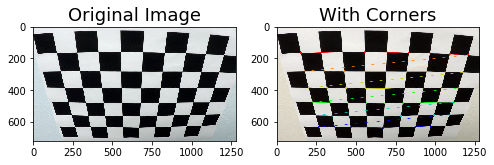

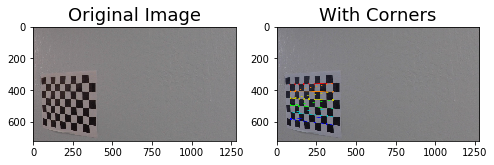

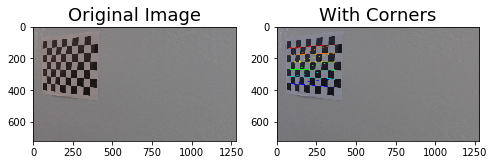

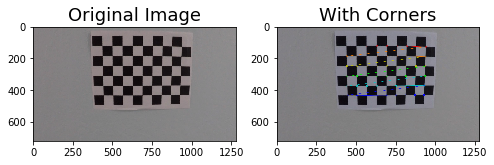

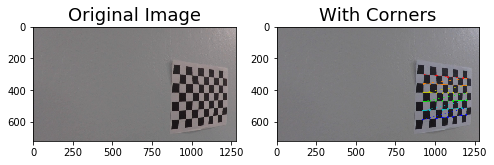

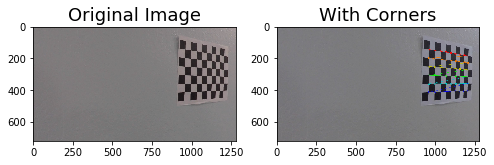

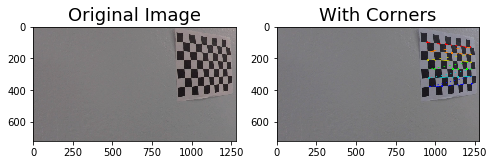

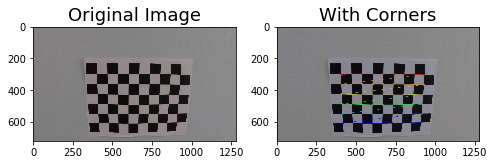

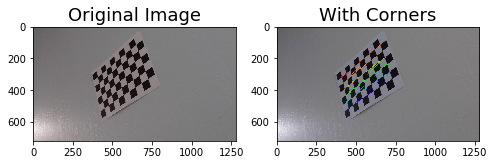

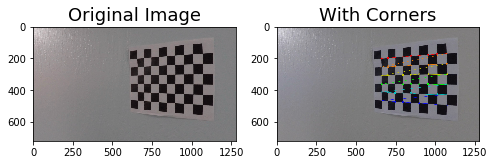

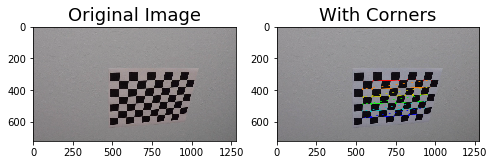

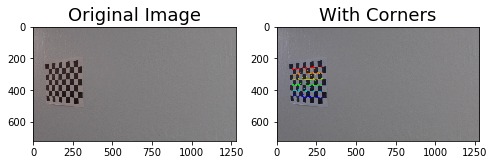

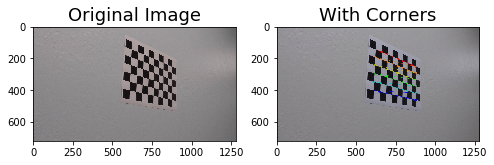

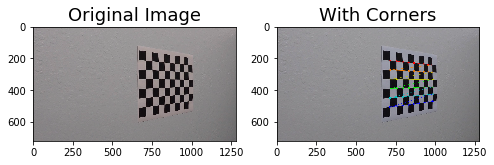

In [3]:
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

nx = 9  # number of corners in x direction
ny = 6  # number of corners in y direction

# Object points
objp = np.zeros((nx * ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx,0:ny].transpose().reshape(-1,2)

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=18)

Define an `undistort` function that uses the above distortion correction parameters to calibrate the camera and then undistort the image.

In [4]:
def undistort(img_name, show_plot=False):
    
    img = cv2.imread(img_name)
    
    # Note: this is inefficient to recalibrate each time, and in 
    # a real system this would only happen once and the result would
    # saved
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        None,
        None
    )
    
    undistorted = cv2.undistort(
        img,
        mtx,
        dist,
        None,
        mtx
    )
    
    if show_plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image', fontsize=20)
    
    return undistorted
    

Loop over all images and undistort and display them

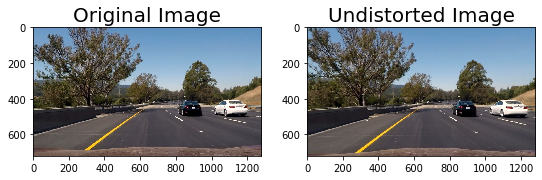

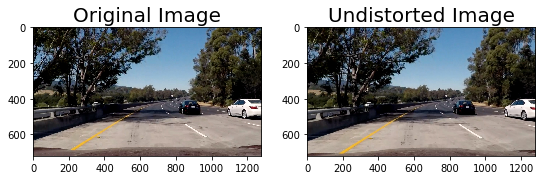

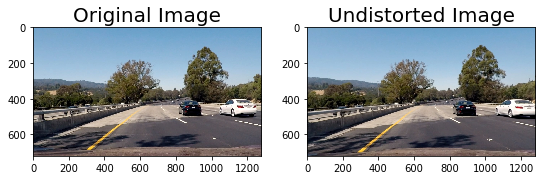

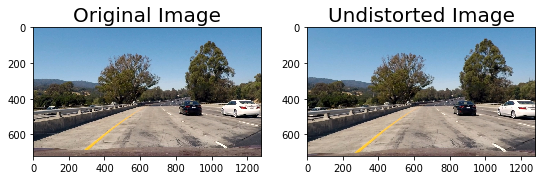

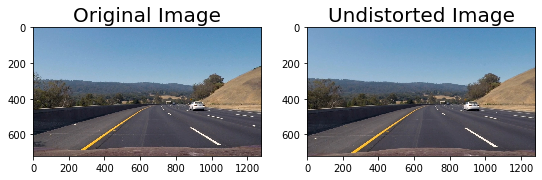

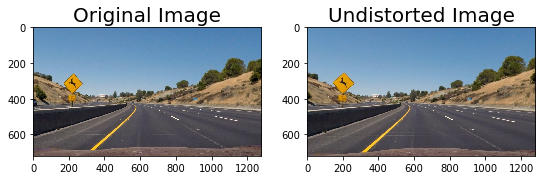

In [5]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(image,show_plot=True)

## Step 2 - Perspective transform

Choose the source region

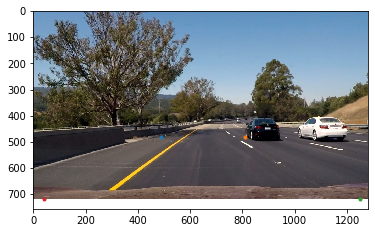

In [6]:
src_pts = np.array(
    [[490, 482], # top left
    [810, 482],  # top right
    [1250, 720], # bottom right
    [40, 720]],   # bottom left
    dtype = "float32"
)
img = mpimg.imread("test_images/test6.jpg")
plt.imshow(img)
for src_pt in src_pts:
    plt.plot(src_pt[0], src_pt[1], ".")

Choose the destination region which the source region will be transformed into (nearly entire image)

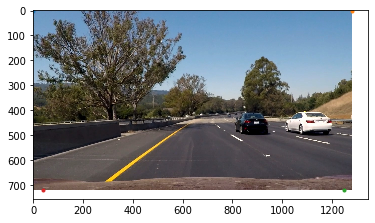

In [7]:
dest_pts = np.array(
    [[0, 0],
    [1280, 0],
    [1250, 720],
    [40, 720]],
    dtype = "float32"
)
plt.imshow(img)
for dest_pt in dest_pts:
    plt.plot(dest_pt[0], dest_pt[1], ".")

Define the function that will perform the perspective transform using the regions defined above

In [11]:
def perspective_transform(image_name, show_plot=False):
        
    # First, undistort
    img = undistort(image_name,show_plot=False)
    
    img_size = (img.shape[1], img.shape[0])
    
    # Perform perspective transform
    M = cv2.getPerspectiveTransform(src_pts, dest_pts)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    if show_plot:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Warped Image', fontsize=20)
    
    return warped

Apply undistortion + perspective transform to all test images

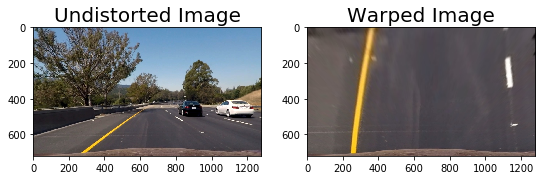

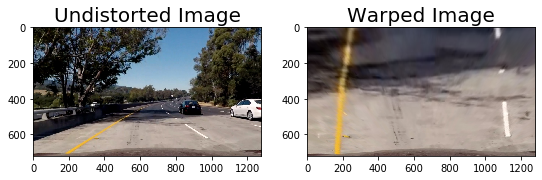

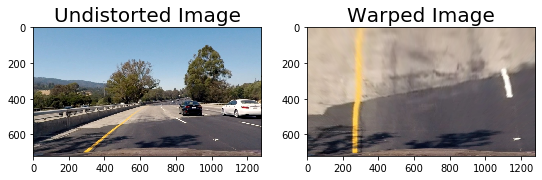

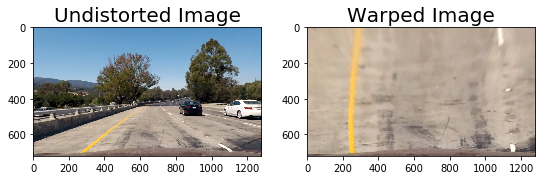

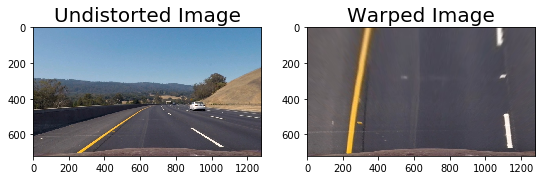

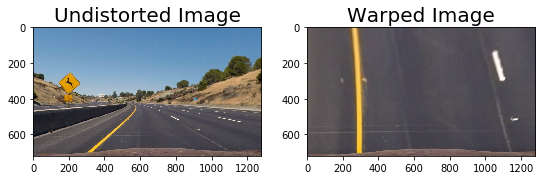

In [12]:
images = glob.glob('test_images/test*.jpg')
for image_name in images:
    warped = perspective_transform(image_name,show_plot=True)
    image_name_no_path = os.path.split(image_name)[-1]
    image_name_no_ext = os.path.splitext(image_name_no_path)[0]
    warped_image_name = image_name_no_ext + "-warped" + ".jpg"
    warped_image_path = os.path.join("intermediate_images", warped_image_name)
    cv2.imwrite(warped_image_path, warped)


## Step 3: Apply color thresholds to create a binary image

In [10]:
# 